In [5]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

import nbfinder
import numpy as np
from scipy.stats import norm
from math import ceil
from math import log
from Level_set_function import Sinusoidal
from functools import reduce 

# Do partition to generate new sub-region
def partition1(undecided_region,cut_dim, S_dist, B ,epsilon1, all_sort_x, all_sort_ds):
    num_of_region = undecided_region.shape[0]
    num_of_dimension = undecided_region.shape[1]     
    previous_pts_in_new_subregion = []
    previous_ds_in_new_subregion = []
    new_range_list = np.array([]).reshape(0,num_of_dimension,2)
    par_eli_check = True
    for nor in range(num_of_region):
        dist = np.linalg.norm(undecided_region[nor, :, 1] - undecided_region[nor, :, 0])  #longest euclidean distance of sub-regions
        # in this iteration, the regions are UNbranchable
        if dist < S_dist * epsilon1:
            branch = False
            par_eli_check = False
            new_range_list = np.append(new_range_list, undecided_region[nor].reshape(1,num_of_dimension,2))
            previous_pts_in_new_subregion.append(all_sort_x[nor])
            previous_ds_in_new_subregion.append(all_sort_ds[nor])
 
        # in this iteration, the region are branchable
        else:
            branch = True 
            component = np.copy(undecided_region[nor])
            temp_previous_pts = np.copy(all_sort_x[nor])
            temp_previous_ds = np.copy(all_sort_ds[nor])
            distance_subregion = round((undecided_region[nor, cut_dim, 1] - undecided_region[nor, cut_dim, 0]) / B, 5)           
            for b in range(B):
                u_l_value = np.array([undecided_region[nor, cut_dim,0]+b*distance_subregion, undecided_region[nor,cut_dim,0]
                                        + (b + 1) * distance_subregion]) # start_end value in a sub-region
                count_pts = sum(temp_previous_pts[:,cut_dim] < u_l_value[1])
                if count_pts < 2:
                    par_eli_check = False
                previous_pts_in_new_subregion.append(temp_previous_pts[:count_pts]) 
                previous_ds_in_new_subregion.append(temp_previous_ds[:count_pts])
                temp_previous_pts = temp_previous_pts[count_pts:]
                temp_previous_ds = temp_previous_ds[count_pts:]
                component[cut_dim] = u_l_value
                component = component.reshape(1, num_of_dimension, 2)
                new_range_list = np.append(new_range_list,component, axis=0)
                component = np.copy(undecided_region[nor])    
    
    return branch,par_eli_check,new_range_list, previous_pts_in_new_subregion,previous_ds_in_new_subregion


# calculate the prob(feasbile) and prob(infeasible) of one sub-region
def p_feasibility(distance_matrix,ref):
    num_of_constraint = len(ref)
    meanStd_matrix = np.zeros([num_of_constraint,2])
    for i in range(num_of_constraint):
        parameter = [np.average(distance_matrix[:,i]),np.std(distance_matrix[:,i],ddof=1)]
        meanStd_matrix[i] = np.array(parameter)
    
    p_feasible = 1
    for i in range(num_of_constraint):
        if meanStd_matrix[i,1] == 0:
            meanStd_matrix[i,1] = 0.000001 
        p_feasible *= (1-norm.cdf(ref[i],meanStd_matrix[i,0],meanStd_matrix[i,1])) 
    p_infeasible = 1 - p_feasible   
    
    return p_feasible, p_infeasible, meanStd_matrix

# sort previous iteration points in order to allocate those points into new generated sub-region
def sortPoints(num_of_dimension,num_of_constraint,cut_dim,all_X,all_distance_matrix):
    all_sort_X = []  
    all_sort_distance_matrix = []
    for nor in range(len(all_X)):
        sort_X = np.array(all_X[nor])[np.array(all_X[nor])[:,cut_dim].argsort()]
        sort_ds = np.array(all_distance_matrix[nor])[np.array(all_X[nor])[:,cut_dim].argsort()]
        all_sort_X.append(sort_X)
        all_sort_distance_matrix.append(sort_ds)
    return all_sort_X,all_sort_distance_matrix 

# pick N points in each current sub-region
def pickPoint1(undecided_region,num_of_constraint,iteration,alpha,delta,total_pts,previous_pts_in_new_subregion,previous_ds_in_new_subregion):
    num_of_region = undecided_region.shape[0]
    num_of_dimension = undecided_region.shape[1] 
    N = ceil(log(alpha / ((2) ** iteration)) / log(1 - delta))  # number of sample point we need in one sub-region
    enter_partition = False
    all_distance_matrix = []
    all_X = []  
    if len(previous_pts_in_new_subregion) == 0: 
        total_pts += N * num_of_region        
        distance_matrix = np.array([]).reshape(0,num_of_constraint)
        for nor in range(num_of_region):
            X = np.zeros((N,num_of_dimension)) # for one region
            for d in range(num_of_dimension):
                X[:,d] = np.random.uniform(undecided_region[nor, d, 0], undecided_region[nor, d, 1], N)           
            for n in range(N):  
                result = Sinusoidal(X[n])  
                distance_matrix = np.append(distance_matrix,result[1].reshape(1,num_of_constraint),axis = 0) 
            all_X.append(X)
            all_distance_matrix.append(distance_matrix)        
    
    #there are previous pts in this iteration                                     
    else:
        for nor in range(num_of_region):        
            num_of_additional_pts_in_one_region = N - len(previous_pts_in_new_subregion[nor])
            if num_of_additional_pts_in_one_region < 0:
                num_of_additional_pts_in_one_region = 0
            total_pts += num_of_additional_pts_in_one_region
            addition_pts = np.zeros((num_of_additional_pts_in_one_region,num_of_dimension))            
            for d in range(num_of_dimension):
                addition_pts[:,d] = np.random.uniform(undecided_region[nor, d, 0], undecided_region[nor, d, 1], num_of_additional_pts_in_one_region)
            add_distance_matrix = np.array([]).reshape(0,num_of_constraint)
            for n in range(num_of_additional_pts_in_one_region):
                result = Sinusoidal(addition_pts[n]) 
                add_distance_matrix = np.append(add_distance_matrix,result[1].reshape(1,num_of_constraint),axis = 0)
            all_X.append(np.append(previous_pts_in_new_subregion[nor],addition_pts, axis = 0))
            all_distance_matrix.append(np.append(previous_ds_in_new_subregion[nor],add_distance_matrix,axis = 0))
    return total_pts,all_X,all_distance_matrix

# handel all regions
def prob_infeasible(undecided_region,distance_matrix,ref):
    num_constraint = len(ref)
    p_feasible_list = []
    p_infeasible_list = []
    for nor in range(len(undecided_region)):
        p_feasible, p_infeasible, meanStd_matrix = p_feasibility(distance_matrix[nor],ref)
        p_feasible_list.append(p_feasible)
        p_infeasible_list.append(p_infeasible)
                
    return p_feasible_list,p_infeasible_list

# critera to decide maintain/eliminate/undecided regions
def prob_prune(undecided_region,distance_matrix,ref,X):
    dim = undecided_region.shape[1]
    num_constraint = len(ref)
    p_feasible_list =[]
    p_infeasible_list =[]    
    remaining1_list = np.array([]).reshape(0,dim,2) # new undecided region
    maintain_region = np.array([]).reshape(0,dim,2)
    prob_eli_undecide = []
    prob_eli_eli = []
    prob_eli_maintain =[]
    all_X =[]
    all_distance_matrix = []
    all_meanStd_matrix = []
    best_l_quantile = []  # which is all constraints l_quantile for best region
    all_con_lu_quantile = np.zeros([len(undecided_region),num_constraint,2])   # 2 is for u_Q and l_Q

    for nor in range(len(undecided_region)):
        p_feasible, p_infeasible, meanStd_matrix = p_feasibility(distance_matrix[nor],ref)
        p_feasible_list.append(p_feasible)
        for c in range(num_constraint):
            all_con_lu_quantile[nor,c,0] = norm.ppf(0.025,meanStd_matrix[c,0],meanStd_matrix[c,1])
            all_con_lu_quantile[nor,c,1] = norm.ppf(0.975,meanStd_matrix[c,0],meanStd_matrix[c,1])
        all_meanStd_matrix.append(meanStd_matrix)
    best_region_index = p_feasible_list.index(max(p_feasible_list))
    best_l_Q = all_con_lu_quantile[best_region_index,:,0]
            
    for nor in range(len(undecided_region)):   
        u_Q = all_con_lu_quantile[nor,:,1]
        l_Q = all_con_lu_quantile[nor,:,0]
        if np.any(u_Q < np.array(ref)) and np.any(u_Q < best_l_Q):
            continue
        elif np.all(l_Q > np.array(ref)):
            maintain_region = np.append(maintain_region,undecided_region[nor].reshape(1,dim,2),axis = 0)
        else:
            remaining1_list = np.append(remaining1_list,undecided_region[nor].reshape(1,dim,2),axis = 0)
            all_X.append(X[nor])
            all_distance_matrix.append(distance_matrix[nor])

    return maintain_region,remaining1_list, all_X, all_distance_matrix, prob_eli_undecide, prob_eli_eli,prob_eli_maintain

In [9]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

import nbfinder
from Level_set_function import Sinusoidal
import numpy as np
import pandas as pd
import time
from scipy.stats import norm 



B = 3       # partition regions into B sub-regions
delta = 0.1
alpha = 0.25
epsilon1 = 0 # terminating PBnB if one side of subregion is less than epsilon% of initial region side
dim=2
x_star = np.array([90]*dim) # true global optimal 
ini_range_list = np.array([0,180]*dim).reshape((1, dim, 2))
ini_range_list = ini_range_list.astype(float)
S_dist = np.linalg.norm(ini_range_list[0, :, 1] - ini_range_list[0, :, 0])  # longest euclidean distance in initial region S
ref = [0]
num_of_constraint = len(ref)
np_all_data = np.array([]).reshape(0,7)

for i in range(1):    
    print('----------------phase1------------------')
    print(time.strftime("%d/%m/%Y %H:%M:%S"))
    start1 = time.time()
    total_pts1 = 0
    iteration1 = 1
    enter_partition = True
    branch = True
    previous_pts_in_new_subregion = []
    previous_ds_in_new_subregion = []
    all_maintain_region = np.array([]).reshape(0, dim, 2)
    #pick initial points in original region
    undecided_region = np.copy(ini_range_list)
    total_pts1,all_X,all_distance_matrix = pickPoint1(undecided_region,num_of_constraint
                                            ,iteration1,alpha,delta,total_pts1,previous_pts_in_new_subregion
                                            ,previous_ds_in_new_subregion)    
    while(branch and iteration1<8): # iteration1<8 is the other criteria to terminate PBnB 
        p_eliminate_matrix = np.zeros([dim]) 
        
        print('iter',iteration1) 
                        
        ############################## the section is to choose the partition side by select Max(pro(feasibility))##############################
        for cut_dim in range(dim):

            all_sort_X,all_sort_ds = sortPoints(dim,num_of_constraint,cut_dim,all_X
                                                                ,all_distance_matrix)
            branch,par_eli_check,new_range_list, previous_pts_in_new_subregion,previous_ds_in_new_subregion = partition1(undecided_region,cut_dim, S_dist, B ,epsilon1, all_sort_X,all_sort_ds)
            if branch == False:
                break
            elif par_eli_check:
                p_feasible_list,p_infeasible_list = prob_infeasible(new_range_list,previous_ds_in_new_subregion,ref)
                p_eliminate_matrix[cut_dim] = max(max(p_infeasible_list),max(p_feasible_list))
                
        cut_dim = np.where(p_eliminate_matrix == np.max(p_eliminate_matrix))
        cut_dim = np.random.choice(cut_dim[0])
        #######################################################################################################
        
        
        all_sort_X,all_sort_ds = sortPoints(dim,num_of_constraint,cut_dim,all_X,all_distance_matrix)
        branch,par_eli_check,new_range_list, previous_pts_in_new_subregion,previous_ds_in_new_subregion = partition1(undecided_region,cut_dim, S_dist, B ,epsilon1, all_sort_X,all_sort_ds)

        total_pts1,all_X,all_distance_matrix = pickPoint1(new_range_list,num_of_constraint
                                                        ,iteration1,alpha,delta,total_pts1,previous_pts_in_new_subregion
                                                        ,previous_ds_in_new_subregion)
       
        maintain_region,undecided_region,all_X, all_distance_matrix, prob_eli_undecide, prob_eli_eli, prob_eli_maintain = prob_prune(
                                                      new_range_list,all_distance_matrix,ref,all_X)

        iteration1+=1
        print('total_pts',total_pts1)
        all_maintain_region = np.append(all_maintain_region, maintain_region, axis = 0)    

    end1 = time.time()
    run_time1 = end1 - start1
    print('point1',total_pts1)
    print(time.strftime("%d/%m/%Y %H:%M:%S"))
        
        


----------------phase1------------------
17/02/2018 16:20:11
iter 1
cut_dim 1
total_pts 60
iter 2
cut_dim 0
total_pts 243
iter 3
cut_dim 1
total_pts 891
iter 4
cut_dim 0
total_pts 2892
iter 5
cut_dim 0
total_pts 4912
iter 6
cut_dim 1
total_pts 9952
iter 7
cut_dim 1
total_pts 18207
point1 18207
17/02/2018 16:20:12


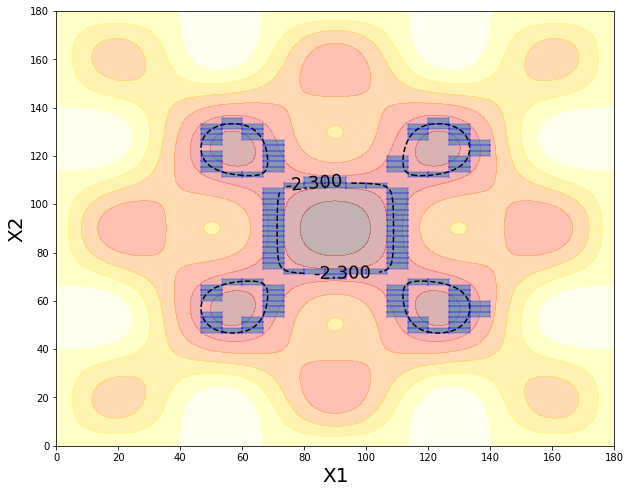

In [10]:
connected_list = undecided_region
import matplotlib.patches as patches
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import math
fig1 = plt.figure(figsize=(10,8))

plt.axis([0,180,0,180])



x1_range=np.linspace(0, 180, 300)
x2_range=np.linspace(0, 180, 300)
X1, X2=np.meshgrid(x1_range, x2_range)
fx = lambda x1,x2:-2.5*np.sin(math.pi*(x1)/180)*np.sin(math.pi*(x2)/180)-np.sin(math.pi*(x1)/(36))*np.sin(math.pi*(x2)/(36)) 

fxv = fx(X1, X2)
CS = plt.contour(X1, X2,fxv,[-2.3],colors='k')
plt.clabel(CS, fontsize =18)
plt.contourf(X1, X2, fxv,alpha = 0.3,cmap = plt.cm.hot) 
plt.clabel(CS, fontsize =18)

ax1 = fig1.add_subplot(111)
for i in range(len(connected_list)):
    ax1.add_patch(patches.Rectangle((connected_list[i,0,0],connected_list[i,1,0]),
                                    connected_list[i,0,1]-connected_list[i,0,0],
                                   connected_list[i,1,1]-connected_list[i,1,0],alpha=0.5))
    plt.axvline(connected_list[i,0,0],connected_list[i,1,0]/180,connected_list[i,1,1]/180,color='b',alpha=0.2)
    plt.axvline(connected_list[i,0,1],connected_list[i,1,0]/180,connected_list[i,1,1]/180,color='b',alpha=0.2)
    plt.axhline(connected_list[i,1,0], connected_list[i,0,0]/180,connected_list[i,0,1]/180,color='b',alpha=0.2)
    plt.axhline(connected_list[i,1,1], connected_list[i,0,0]/180,connected_list[i,0,1]/180,color='b',alpha=0.2)
plt.xlabel('X1', fontsize=20)
plt.ylabel('X2',fontsize=20)
#plt.savefig('original_sin-Bad result.jpg',dpi=300)
plt.show()

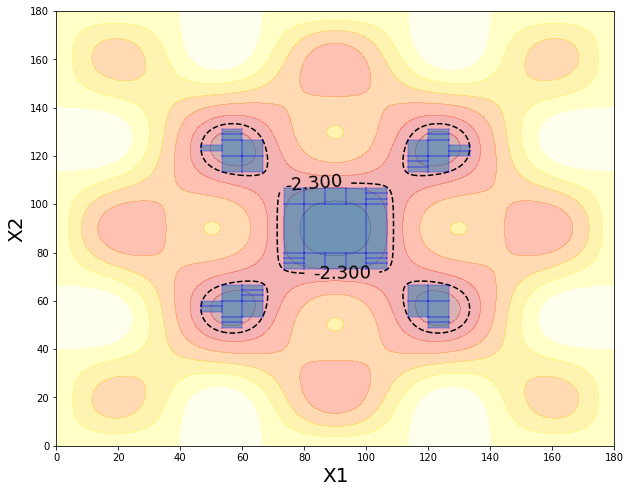

In [11]:
connected_list = all_maintain_region
import matplotlib.patches as patches
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import math
fig1 = plt.figure(figsize=(10,8))

plt.axis([0,180,0,180])



x1_range=np.linspace(0, 180, 300)
x2_range=np.linspace(0, 180, 300)
X1, X2=np.meshgrid(x1_range, x2_range)
fx = lambda x1,x2:-2.5*np.sin(math.pi*(x1)/180)*np.sin(math.pi*(x2)/180)-np.sin(math.pi*(x1)/(36))*np.sin(math.pi*(x2)/(36)) 

fxv = fx(X1, X2)
CS = plt.contour(X1, X2,fxv,[-2.3],colors='k')
plt.clabel(CS, fontsize =18)
plt.contourf(X1, X2, fxv,alpha = 0.3,cmap = plt.cm.hot) 
plt.clabel(CS, fontsize =18)

ax1 = fig1.add_subplot(111)
for i in range(len(connected_list)):
    ax1.add_patch(patches.Rectangle((connected_list[i,0,0],connected_list[i,1,0]),
                                    connected_list[i,0,1]-connected_list[i,0,0],
                                   connected_list[i,1,1]-connected_list[i,1,0],alpha=0.5))
    plt.axvline(connected_list[i,0,0],connected_list[i,1,0]/180,connected_list[i,1,1]/180,color='b',alpha=0.2)
    plt.axvline(connected_list[i,0,1],connected_list[i,1,0]/180,connected_list[i,1,1]/180,color='b',alpha=0.2)
    plt.axhline(connected_list[i,1,0], connected_list[i,0,0]/180,connected_list[i,0,1]/180,color='b',alpha=0.2)
    plt.axhline(connected_list[i,1,1], connected_list[i,0,0]/180,connected_list[i,0,1]/180,color='b',alpha=0.2)
plt.xlabel('X1', fontsize=20)
plt.ylabel('X2',fontsize=20)
#plt.savefig('original_sin-Bad result.jpg',dpi=300)
plt.show()